In [39]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,Embedding, ReLU,concatenate,Cropping2D, BatchNormalization

from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-07-20 20:43:22.282915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
image_path = '../dados/CAPTCHA-10k/teste'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,009001.jpg,JW4CZF
1,009002.jpg,H27LCM
2,009003.jpg,1EF8W0
3,009004.jpg,HZ1HQE
4,009005.jpg,97CZ9Z


In [4]:
df['txt_content'].str.len().value_counts()

txt_content
6    999
7      1
Name: count, dtype: int64

In [5]:
vocab = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '*']
np.array(vocab)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '*'],
      dtype='<U1')

In [6]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [7]:
def generate_X_Y(image_path):
  df = generate_df(image_path)

  df["index"] = [f"{i}" for i in range(len(df))]
  file_index = (df["index"] + " ") * df['txt_content'].str.len()
  file_index = file_index.sum().split(" ")
  file_index = [int(x) for x in file_index if x] 

  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)


  X   = X[file_index]
  pos = np.array([i for text in df["txt_content"] for i,char in enumerate(text)]).reshape(-1,1)
  
  rows = []
  for row_index, text in enumerate(df["txt_content"]):
      for char_index, char in enumerate(text):
         rows.append(row_index)


  X = X.astype('float32') / 255.
  return X,pos,rows

X_teste,pos_teste,rows_teste = generate_X_Y('../dados/CAPTCHA-10k/teste')

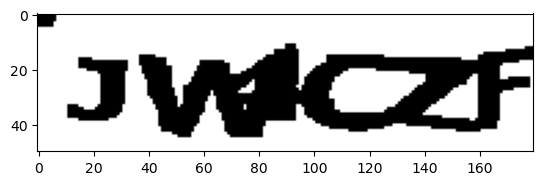

In [8]:
plt.imshow(X_teste[0], cmap='gray')

In [30]:
df["preds"] = ""

In [9]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [10]:
autoencoder = tf.keras.models.load_model('model_BCE_aug_best_unet.tf',custom_objects={"rmse": rmse,"psnr":psnr})
classifier  = tf.keras.models.load_model('classifier_aug_best.tf')

2024-07-20 20:43:24.391260: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13905 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [18]:
aes = autoencoder.predict([X_teste,pos_teste])

188/188 [==============================] - 4s 19ms/step


In [19]:
preds = classifier.predict(aes)

188/188 [==============================] - 1s 3ms/step


In [23]:
one_hot = np.argmax(preds,axis=-1)
preds = np.array([vocab[p] for p in one_hot])

In [31]:
for i in range(len(preds)):
    row = rows_teste[i]
    df.loc[row,"preds"] += preds[i]

In [33]:
df

,jpg_file,txt_content,preds
0,009001.jpg,JW4CZF,JW4CZF
1,009002.jpg,H27LCM,H27LCM
2,009003.jpg,1EF8W0,IEF8W0
3,009004.jpg,HZ1HQE,HZ1HQE
4,009005.jpg,97CZ9Z,97CZ9Z
...,...,...,...
995,009996.jpg,66ZDPA,66ZDPA
996,009997.jpg,2044B3,2044B3
997,009998.jpg,SNB9SO,SNB9SC
998,009999.jpg,0DTW1D,0DTWID


In [37]:
def count_matches(row):
    txt_content = row['txt_content']
    pred = row['preds']
    return sum(1 for a, b in zip(txt_content, pred) if a == b)

# Apply the function to each row
df['matches'] = df.apply(count_matches, axis=1)
df

,jpg_file,txt_content,preds,matches
0,009001.jpg,JW4CZF,JW4CZF,6
1,009002.jpg,H27LCM,H27LCM,6
2,009003.jpg,1EF8W0,IEF8W0,5
3,009004.jpg,HZ1HQE,HZ1HQE,6
4,009005.jpg,97CZ9Z,97CZ9Z,6
...,...,...,...,...
995,009996.jpg,66ZDPA,66ZDPA,6
996,009997.jpg,2044B3,2044B3,6
997,009998.jpg,SNB9SO,SNB9SC,5
998,009999.jpg,0DTW1D,0DTWID,5


In [75]:
df[df["txt_content"] != df["preds"]].sample(100).head()

,jpg_file,txt_content,preds,matches
720,009721.jpg,AZNAWY,AZNAW?,5
532,009533.jpg,R0I825,RQI825,5
392,009393.jpg,CM4EWL,CM4EW?,5
191,009192.jpg,BTC6AO,BTG6AO,5
763,009764.jpg,V9NWRD,W9NWRD,5


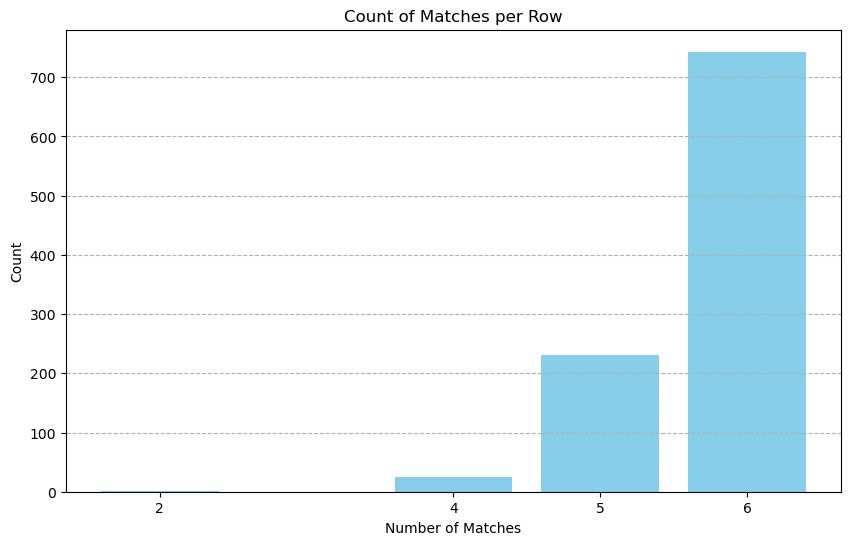

In [42]:
match_counts = df['matches'].value_counts().sort_index()

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(match_counts.index, match_counts.values, color='skyblue')
plt.xlabel('Number of Matches')
plt.ylabel('Count')
plt.title('Count of Matches per Row')
plt.xticks(match_counts.index)  # Ensure x-axis labels match the match counts
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

In [76]:
miss = (df["matches"] != df["txt_content"].str.len()).sum()
acc = (len(df) - miss)/len(df)
acc

0.743

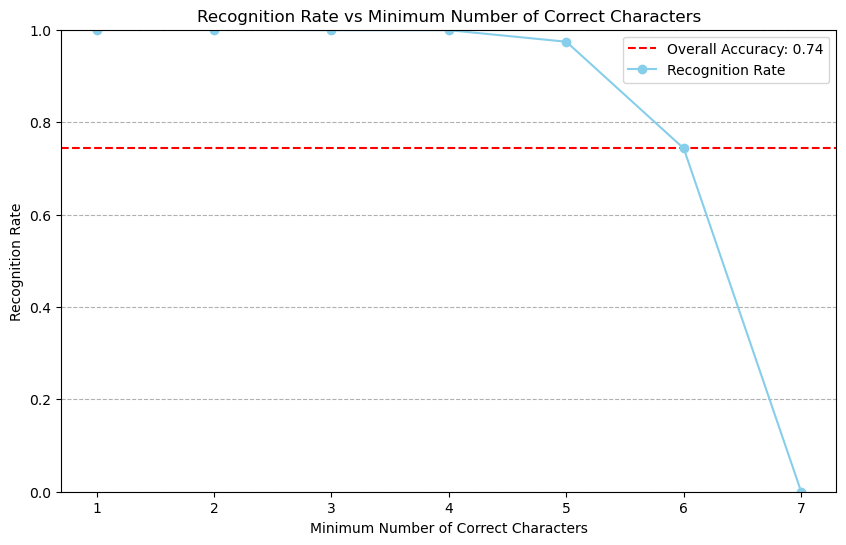

In [79]:
# Calculate recognition rates
max_chars = df['txt_content'].map(len).max()
recognition_rates = []

for min_correct in range(1, max_chars + 1):
    count_correct = df['matches'] >= min_correct
    rate = count_correct.mean()
    recognition_rates.append(rate)

# Plot the recognition rates
plt.figure(figsize=(10, 6))
plt.axhline(y=acc, color='r', linestyle='--', label=f'Overall Accuracy: {acc:.2f}')
plt.plot(range(1, max_chars + 1), recognition_rates, marker='o', color='skyblue', label='Recognition Rate')
plt.xlabel('Minimum Number of Correct Characters')
plt.ylabel('Recognition Rate')
plt.title('Recognition Rate vs Minimum Number of Correct Characters')
plt.grid(axis='y', linestyle='--')
plt.ylim(0, 1)
plt.xticks(range(1, max_chars + 1))
plt.legend()
plt.show()

In [56]:
miss = (df["matches"] != df["txt_content"].str.len()).sum()
miss,(len(df) - miss)/len(df)

(257, 0.743)